In [0]:
# Ensure latest TensorFlow is installed.
# !pip install -q tf-nightly-gpu-2.0-preview
# Load the TensorBoard notebook extension.
# %load_ext tensorboard

     |████████████████████████████████| 391.5MB 50kB/s 
     |████████████████████████████████| 3.8MB 27.9MB/s 
     |████████████████████████████████| 450kB 44.0MB/s 


In [0]:
import tensorflow as tf
import datetime, os

In [0]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(x_train, y_train),(x_test, y_test) = fashion_mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

4423680/4422102 [==============================] - 0s 0us/step


In [0]:
def create_model():
  return tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation='softmax')
  ])

In [0]:
def train_model():
  
  model = create_model()
  model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

  logdir = os.path.join("./Graph", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

  model.fit(x=x_train, 
            y=y_train, 
            epochs=5, 
            validation_data=(x_test, y_test), 
            callbacks=[tensorboard_callback])

train_model()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 15s 248us/sample - loss: 0.5007 - acc: 0.8205 - val_loss: 0.4185 - val_acc: 0.8516
Epoch 2/5
60000/60000 [==============================] - 14s 234us/sample - loss: 0.3839 - acc: 0.8601 - val_loss: 0.4268 - val_acc: 0.8460
Epoch 3/5
60000/60000 [==============================] - 14s 232us/sample - loss: 0.3527 - acc: 0.8702 - val_loss: 0.3677 - val_acc: 0.8628
Epoch 4/5
60000/60000 [==============================] - 14s 234us/sample - loss: 0.3260 - acc: 0.8798 - val_loss: 0.3755 - val_acc: 0.8655
Epoch 5/5
60000/60000 [==============================] - 14s 233us/sample - loss: 0.3136 - acc: 0.8847 - val_loss: 0.3686 - val_acc: 0.8656


In [0]:
# !ls

# Graph on Tensorbord

In [0]:
LOG_DIR = './Graph'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)



In [0]:
! wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
! unzip ngrok-stable-linux-amd64.zip

--2019-09-22 08:28:26--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.54.237.49, 52.204.136.9, 52.204.38.150, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.54.237.49|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13607069 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  12.98M  14.5MB/s    in 0.9s    

2019-09-22 08:28:27 (14.5 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13607069/13607069]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [0]:
get_ipython().system_raw('./ngrok http 6006 &')

In [0]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

http://f753dd34.ngrok.io


# AUG in tf

[FastNet](https://github.com/faizanahemad/FastNet/blob/master/examples/TFRecords_Image_augmentations.ipynb)

[FastNet](https://github.com/faizanahemad/FastNet)

[FastNet](https://github.com/faizanahemad/FastNet/blob/master/examples/TFRecord_Benchmarks.ipynb)

[tensorboard_profiling_keras](https://www.tensorflow.org/tensorboard/r2/tensorboard_profiling_keras)

[Aug_in_TF](https://www.wouterbulten.nl/blog/tech/data-augmentation-using-tensorflow-data-dataset/)


[tflearn](https://github.com/tflearn/tflearn/tree/master/tflearn)

In [0]:
import tensorflow as tf

In [0]:
tf.__version__

'1.14.0'

In [0]:
import numpy as np
import tensorflow as tf
import os

import logging
logger = logging.getLogger("Image Augmentations")
logger.setLevel(logging.INFO)
import tensorflow_datasets as tfds

def replace_slice(input_: tf.Tensor, replacement, begin) -> tf.Tensor:
    inp_shape = tf.shape(input_)
    size = tf.shape(replacement)
    padding = tf.stack([begin, inp_shape - (begin + size)], axis=1)
    replacement_pad = tf.pad(replacement, padding)
    mask = tf.pad(tf.ones_like(replacement, dtype=tf.bool), padding)
    return tf.where(mask, replacement_pad, input_)


def get_cutout_eraser(minimum, maximum, area: int = 81, c: int = 3, min_aspect_ratio=0.5, max_aspect_ratio=1 / 0.5):
    sqrt_area = np.sqrt(area)

    def get_h_w(aspect_ratio):
        h = sqrt_area / aspect_ratio
        w = tf.math.round(area / h)
        h = tf.math.round(h)
        h = tf.cast(h, tf.int32)
        w = tf.cast(w, tf.int32)
        return h, w

    def tf_cutout(x: tf.Tensor) -> tf.Tensor:
        """
        Cutout data augmentation. Randomly cuts a h by w whole in the image, and fill the whole with zeros.
        :param x: Input image.
        :param h: Height of the hole.
        :param w: Width of the hole
        :param c: Number of color channels in the image. Default: 3 (RGB).
        :return: Transformed image.
        """
        dtype = x.dtype
        minval = tf.cast(minimum, dtype=dtype)
        maxval = tf.cast(maximum, dtype=dtype)

        aspect_ratio = tf.random.uniform([], min_aspect_ratio, max_aspect_ratio)
        h, w = get_h_w(aspect_ratio)

        shape = tf.shape(x)
        x0 = tf.random.uniform([], 0, shape[1] + 1 - h, dtype=tf.int32)
        y0 = tf.random.uniform([], 0, shape[2] + 1 - w, dtype=tf.int32)

        slic = tf.random.uniform([shape[0], h, w, c], minval=minval, maxval=maxval, dtype=dtype)
        x = replace_slice(x, slic, [0, x0, y0, 0])
        return x

    return tf_cutout


def get_hue_aug(max_delta):
    return lambda x: tf.image.random_hue(x,max_delta=max_delta)


def get_brightness_aug(max_delta):
    return lambda x: tf.image.random_brightness(x,max_delta=max_delta)


def get_contrast_aug(max_delta):
    return lambda x: tf.image.random_contrast(x,max_delta=max_delta)


def get_saturation_aug(lower,upper):
    return lambda x: tf.image.random_saturation(x,lower=lower,upper=upper)


def get_hflip_aug():
    return lambda x: tf.image.random_flip_left_right(x)


def get_random_pad_crop(pad_height,pad_width, cropped_height,cropped_width):
    def transformer(x):
        shape = tf.shape(x)
        paddings = [[0,0],[pad_height,pad_height],[pad_width,pad_width],[0,0]]
        x = tf.pad(x,paddings,mode='REFLECT',)
        return tf.image.random_crop(x, [shape[0], cropped_height, cropped_width, shape[3]])
    return transformer


def get_first_argument_transformer(fn):
    def transformer_wrapper(x: tf.Tensor, *args):
        return tuple([fn(x)]+list(args))
    return transformer_wrapper


def combine_transformers(*transformers):
    # wraping all indivisual aug #Taking more time copare to map.
    def wrapper(*args):
        for t in transformers:
            args = t(*args)
        return tuple(args)
    return wrapper

In [0]:
# pip install --upgrade --upgrade-strategy only-if-needed https://github.com/faizanahemad/FastNet/tarball/master

In [0]:
import fastnet as fn
random_pad_crop = get_first_argument_transformer(get_random_pad_crop(4,4,32,32))
cutout = get_first_argument_transformer(get_cutout_eraser(0,255))
hflip = get_first_argument_transformer(get_hflip_aug())

transformations = combine_transformers(random_pad_crop,hflip,cutout)

transformation = combine_transformers(get_hflip_aug, get_random_pad_crop)

In [0]:
cifar_builder = tfds.builder('cifar10')
cifar_builder.download_and_prepare()

In [0]:
train_data = cifar_builder.as_dataset(split=tfds.Split.TRAIN)

In [0]:
train_data

<_OptionsDataset shapes: {image: (32, 32, 3), label: ()}, types: {image: tf.uint8, label: tf.int64}>

In [0]:
%%timeit
batch_size = 512
imgs = 50000
batches = imgs//batch_size
cf10_ex = []
train,test = fn.get_cifar10("cifar10",batch_size)
for x,y in train.map(random_pad_crop).map(cutout).map(hflip).take(batches):
    cf10_ex.append(tf.shape(x))

# testing repo.

In [0]:
# 
pip install --upgrade --upgrade-strategy only-if-needed https://github.com/kkrunal77/data_science_utils/tarball/master


     - 10kB 2.7MB/s
  Created wheel for data-science-utils: filename=data_science_utils-0.0.0-cp36-none-any.whl size=7473 sha256=6788ff52c40db5ef54ea385bfd2ee7773b232a43c58c00b01fa2bd74441c6cac
  Stored in directory: /tmp/pip-ephem-wheel-cache-wj6v8tyn/wheels/72/1a/9f/4d1aadec4afb9693f42c521c5be90d606f56f435ba21e38756
Successfully built data-science-utils
  Found existing installation: data-science-utils 0.0.0
    Uninstalling data-science-utils-0.0.0:
      Successfully uninstalled data-science-utils-0.0.0


In [0]:
import data_science_utils as kk


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [0]:
kk.combine_transformers

<function data_science_utils.data.augmentations.augmentations.combine_transformers>

In [0]:
train, test = kk.get_cifar10("./",batch_size=128)

# Sufflenet

In [0]:
# !pip install -q tf-nightly-gpu-2.0-preview
import tensorflow as tf
print(tf.__version__)

1.14.0


In [0]:
!wget http://models.tensorpack.com/ImageNetModels/ShuffleNetV1-1x-g=8.npz

--2019-09-19 16:42:39--  http://models.tensorpack.com/ImageNetModels/ShuffleNetV1-1x-g=8.npz
Resolving models.tensorpack.com (models.tensorpack.com)... 185.207.105.29
Connecting to models.tensorpack.com (models.tensorpack.com)|185.207.105.29|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9248798 (8.8M) [application/octet-stream]
Saving to: ‘ShuffleNetV1-1x-g=8.npz’

ShuffleNetV1-1x-g=8 100%[===================>]   8.82M  7.23MB/s    in 1.2s    

2019-09-19 16:42:40 (7.23 MB/s) - ‘ShuffleNetV1-1x-g=8.npz’ saved [9248798/9248798]



In [0]:
!ls

 sample_data  'ShuffleNetV1-1x-g=8.npz'


[Tensorflow-Shufflenet](https://github.com/europa1610/Tensorflow-Shufflenet)

In [0]:
import tensorflow as tf
import numpy as np
import time

SHUFFLENET_MEAN = [103.939, 116.779, 123.68]
NORMALIZER = 0.017
#Parameters credits to https://github.com/MG2033/ShuffleNet

class Shufflenet:
    #Load pretrained model on initialization. Model downloaded from http://models.tensorpack.com/ImageNetModels/ShuffleNetV1-1x-g=8.npz
    def __init__(self, model_loc):
        self.trained_model = np.load(model_loc, encoding = 'latin1')
        print("Pre-trained npz model loaded")
#       Uncomment below 2 lines to check model entries (Kernels for conv), (mean, variance, beta and gamma for BN) and (weights and biases) for final FC layer
        for x in self.trained_model.files:
            print(x + " " + str(self.trained_model[x].shape))

    '''
    Point-wise group convolution operation.
    Inputs:     Activations of shape [N, H, W, C], Stage in format
            'stagex', block in format 'blockx' and layer in
            format 'convx', num_groups are the number of
            groups to split the activations and kernels in.
    Outputs:    Output activations of group convolution result
    '''
    def pw_gconv(self, activations, stage, block, layer, num_groups, name):
        with tf.name_scope(name):
            layer_name = str(stage) + '/' + str(block) + '/' + str(layer) + '/W:0'
            kernels = self.trained_model[layer_name]
            print(kernels.shape)
            ch_per_group = activations.shape[3] // num_groups
            act_split = tf.split(activations, num_or_size_splits = num_groups, axis = 3)
            kernels_split = tf.split(kernels, num_or_size_splits = num_groups, axis = 3)
            convs = []
            for grp in range(0, num_groups):
                convs.append(tf.nn.conv2d(act_split[grp], kernels_split[grp], padding = 'SAME', strides = [1, 1, 1, 1], data_format = 'NHWC', name='pw_gconv_' + str(grp)))
            return tf.concat(convs, axis = 3)

    '''
    Depth-wise convolution operation.
    Inputs:     Activations of shape [N, H, W, C], stage in format 'stagex',
            block in format 'blockx', padding, stride and name to give to
            the node in tensorboard visualization
    Outputs:    Output activations of the dw conv operation
    '''
    def dw_conv(self, activations, stage, block, padding = 'SAME', stride = 1, name="dw_conv"):
        with tf.name_scope(name):
            inp_ch = activations.shape[3]
            act_shape = activations.shape
            layer_name = str(stage) + '/' + str(block) + '/dconv/W:0'
            kernels = self.trained_model[layer_name]
            print(kernels.shape)
            kernel_size = kernels.shape[0]
            conv_result = tf.nn.depthwise_conv2d(activations, kernels, [1, stride, stride, 1], padding = padding, data_format = 'NHWC', name='dw_conv_' + stage + '_' + block)
            return conv_result

    '''
    Batch Normalization operations
    Inputs:     Activations of shape [N, H, W, C], stage in format 'stagex',
            block in format 'blockx', layer in format 'convx' and name to
            give to the node in tensorboard graph summary.
    Outputs:    Output activations of BN operation
    '''
    def batch_normalization(self, activations, stage, block, layer, name):
        with tf.name_scope(name):
            layer_name = str(stage) + '/' + str(block) + '/' if stage is not '' else ''
            layer_name = layer_name + 'conv1/bn/' if layer == 'conv1' else layer_name + layer+'_bn/'
            bn_out = tf.nn.batch_normalization(activations, self.trained_model[layer_name + 'mean/EMA:0'], self.trained_model[layer_name + 'variance/EMA:0'], self.trained_model[layer_name + 'beta:0'], self.trained_model[layer_name + 'gamma:0'], variance_epsilon=0.001, name = 'bn_' + stage + '_' + block + '_' + layer if stage is not '' else 'bn_conv1')
            return bn_out

    '''
    Channel Shuffle Operation. (Credits to Tensorpack Shufflenet Implementation https://github.com/tensorpack/tensorpack/blob/master/examples/ImageNetModels/shufflenet.py)
    Inputs:     Activations of shape [N, H, W, C], num_groups = 8,
            Name to give to the node in tensorboard graph summary.
    Outputs     Activations after ch shuffle op.
    '''
    def channel_shuffle(self, activations, num_groups = 8, name='ch_shuffle'):
        with tf.name_scope(name):
            activations = tf.transpose(activations, perm = [0, 3, 1, 2])
            in_shape = activations.get_shape().as_list()
            in_channel = in_shape[1]
            l = tf.reshape(activations, [-1, in_channel // num_groups, num_groups] + in_shape[-2:])
            l = tf.transpose(l, [0, 2, 1, 3, 4])
            l = tf.reshape(l, [-1, in_channel] + in_shape[-2:])
            l = tf.transpose(l, perm = [0, 2, 3, 1])
            return l

    def shufflenet_unit(self, activations, stage, block, stride, num_groups=8, name="shufflenet_unit"):
        with tf.name_scope(name):
            residual = activations
            num_split = num_groups if activations.shape[3] > 24 else 1
            print("Stage: " + stage + " block: " + block)
            print("inp_act size: " + str(activations.shape))
            pwgconv1 = self.pw_gconv(activations, stage, block, 'conv1', num_split, name= stage + "_" + block + "_pwgconv1")
            print("pwgconv1 size: " + str(pwgconv1.shape))
            bnconv1 = self.batch_normalization(pwgconv1, stage, block, 'conv1', name = stage + "_" + block + "_pwgconv1_batch_norm")
            reluconv1 = tf.nn.relu(bnconv1)
            ch_sh = self.channel_shuffle(reluconv1, num_groups, name = stage + '_' + block + '_ch_shuffle')
            dconv = self.dw_conv(ch_sh, stage, block, padding = 'SAME', stride = stride, name = stage + "_" + block + "_dwconv")
            print("dconv size: " + str(dconv.shape))
            bndconv = self.batch_normalization(dconv, stage, block, 'dconv', name = stage + "_" + block + "_dconv_batch_norm")
            pwgconv2 = self.pw_gconv(bndconv, stage, block, 'conv2', num_groups, name= stage + "_" + block + "_pwgconv2")
            print("pwgconv2 size: " + str(pwgconv2.shape))
            bnconv2 = self.batch_normalization(pwgconv2, stage, block, 'conv2', name = stage + "_" + block + "_pwgconv2_batch_norm")

            if stride == 1:
                return tf.nn.relu(bnconv2 + residual, name = 'relu_' + stage + '_' + block)
            elif stride == 2:
                residual = tf.nn.avg_pool(residual, [1, 3, 3, 1], strides = [1, 2, 2, 1], padding = 'SAME', data_format = 'NHWC', name = 'avg_pool_' + stage + '_' + block)
                return tf.concat([residual, tf.nn.relu(bnconv2)], axis = 3, name = 'concat_' + stage + '_' + block)
            else:
                raise ValueError("Stride value can only be 1 or 2 for Shufflenet")

    def shufflenet_stage(self, activations, stage, repeat, num_groups=8, name = "shufflenet_stage"):
        with tf.name_scope(name):
            first_block = self.shufflenet_unit(activations, stage, 'block0', stride = 2, num_groups = 8, name = "shufflenet_unit_" + stage + "_block0")
            res = first_block
            for b in range(1, repeat+1):
                res = self.shufflenet_unit(res, stage, 'block' + str(b), stride = 1, num_groups = 8, name = "shufflenet_unit_" + stage + "_block" + str(b))
            return res

    def shufflenet_stage1(self, activations):
        with tf.name_scope("shufflenet_stage1"):
            kernels = self.trained_model['conv1/W:0']
            res = tf.nn.conv2d(activations, kernels, padding = 'SAME', strides = [1, 2, 2, 1], data_format = 'NHWC', name = 'Conv1')
            res = self.batch_normalization(res, '', '', 'conv1', name = 'stage1_conv2d_batch_norm')
            res = tf.nn.max_pool(res, [1, 3, 3, 1], strides = [1, 2, 2, 1], padding = 'SAME', data_format = 'NHWC', name = 'MaxPool1')
            return res

    def fc_layer(self, activations):
        with tf.name_scope('fc_layer'):
            layer_name = 'linear'
            weights = self.trained_model[layer_name + '/W:0']
            biases = self.trained_model[layer_name + '/b:0']
            flattened_out = tf.contrib.layers.flatten(activations)
            return tf.nn.bias_add(tf.matmul(flattened_out, weights), biases)

    def build(self, image):
        red, green, blue = tf.split(axis=3, num_or_size_splits=3, value=image)
        bgr = tf.concat(axis=3, values=[(blue - SHUFFLENET_MEAN[0])*NORMALIZER, (green - SHUFFLENET_MEAN[1])*NORMALIZER, (red - SHUFFLENET_MEAN[2])*NORMALIZER])
        stage1 = self.shufflenet_stage1(bgr)
        stage2 = self.shufflenet_stage(stage1, 'stage2', repeat = 3, num_groups = 8, name = "shufflenet_stage2")
        stage3 = self.shufflenet_stage(stage2, 'stage3', repeat = 7, num_groups = 8, name = "shufflenet_stage3")
        stage4 = self.shufflenet_stage(stage3, 'stage4', repeat = 3, num_groups = 8, name = "shufflenet_stage4")
        g_pool = tf.nn.avg_pool(stage4, [1, 7, 7, 1], strides = [1, 1, 1, 1], padding = 'VALID', data_format = 'NHWC', name = 'GlobalPool')
        logits = self.fc_layer(g_pool)
        logits = tf.nn.softmax(logits, name = "SoftMax_unit")
        return logits


In [0]:
model = Shufflenet("./")

IsADirectoryError: ignored

In [0]:
import json
import codecs
import requests
import numpy as np
import pandas as pd 
from PIL import Image
from tqdm import tqdm
from io import BytesIO

In [0]:
from google.colab import files
files.upload()

Saving face_detection.json to face_detection.json


{'face_detection.json': b'{"content": "http://com.dataturks.a96-i23.open.s3.amazonaws.com/2c9fafb064277d86016431e33e4e003d/8186c3d1-e9d4-4550-8ec1-a062a7628787___0-26.jpg.jpeg","annotation":[{"label":["Face"],"notes":"","points":[{"x":0.08615384615384615,"y":0.3063063063063063},{"x":0.1723076923076923,"y":0.45345345345345345}],"imageWidth":650,"imageHeight":333},{"label":["Face"],"notes":"","points":[{"x":0.583076923076923,"y":0.2912912912912913},{"x":0.6584615384615384,"y":0.46846846846846846}],"imageWidth":650,"imageHeight":333}],"extras":null}\n{"content": "http://com.dataturks.a96-i23.open.s3.amazonaws.com/2c9fafb064277d86016431e33e4e003d/d1c32c8e-8050-482d-a6c8-b101ccba5b65___0de0ee708a4a47039e441d488615ebb7.png","annotation":[{"label":["Face"],"notes":"","points":[{"x":0.7053087757313109,"y":0.23260437375745527},{"x":0.7692307692307693,"y":0.36182902584493043}],"imageWidth":1280,"imageHeight":697}],"extras":null}\n{"content": "http://com.dataturks.a96-i23.open.s3.amazonaws.com/2c

In [0]:
# get links and stuff from json
jsonData = []
JSONPATH = "face_detection.json"
with codecs.open(JSONPATH, 'rU', 'utf-8') as js:
    for line in js:
        jsonData.append(json.loads(line))

print(f"{len(jsonData)} image found!")

print("Sample row:")
jsonData[0]

409 image found!
Sample row:


{'annotation': [{'imageHeight': 333,
   'imageWidth': 650,
   'label': ['Face'],
   'notes': '',
   'points': [{'x': 0.08615384615384615, 'y': 0.3063063063063063},
    {'x': 0.1723076923076923, 'y': 0.45345345345345345}]},
  {'imageHeight': 333,
   'imageWidth': 650,
   'label': ['Face'],
   'notes': '',
   'points': [{'x': 0.583076923076923, 'y': 0.2912912912912913},
    {'x': 0.6584615384615384, 'y': 0.46846846846846846}]}],
 'content': 'http://com.dataturks.a96-i23.open.s3.amazonaws.com/2c9fafb064277d86016431e33e4e003d/8186c3d1-e9d4-4550-8ec1-a062a7628787___0-26.jpg.jpeg',
 'extras': None}

In [0]:
import cv2
import os
def resize_and_save_img(img, path, img_name, size=(400, 400)):
    img = np.copy(img)
    new_img = cv2.resize(img, size)
    path = os.path.join(path, img_name)
#     print(path)
    cv2.imwrite(path, img)
    print(f"Writing to {path}")
    

In [0]:
!mkdir images
!mkdir original_images

In [0]:
images = []
i = 1
for data in tqdm(jsonData):
    response = requests.get(data['content'])
    img = np.asarray(Image.open(BytesIO(response.content)))
    img_name = f"img_{str(i).zfill(3)}.jpg"
    resize_and_save_img(img, "./images", img_name)
    resize_and_save_img(img, './original_images', img_name, size=img.shape[:2])
    i+=1
#     print(img_name)
    images.append([img, data["annotation"]])
#     break


  0%|          | 1/409 [00:00<00:58,  6.97it/s]

Writing to ./images/img_001.jpg
Writing to ./original_images/img_001.jpg



  1%|          | 3/409 [00:00<01:01,  6.58it/s]

Writing to ./images/img_002.jpg
Writing to ./original_images/img_002.jpg
Writing to ./images/img_003.jpg
Writing to ./original_images/img_003.jpg



  1%|          | 5/409 [00:00<00:54,  7.35it/s]

Writing to ./images/img_004.jpg
Writing to ./original_images/img_004.jpg
Writing to ./images/img_005.jpg
Writing to ./original_images/img_005.jpg
Writing to ./images/img_006.jpg



  2%|▏         | 7/409 [00:00<00:50,  8.04it/s]

Writing to ./original_images/img_006.jpg
Writing to ./images/img_007.jpg
Writing to ./original_images/img_007.jpg



  2%|▏         | 9/409 [00:01<00:57,  6.99it/s]

Writing to ./images/img_008.jpg
Writing to ./original_images/img_008.jpg
Writing to ./images/img_009.jpg
Writing to ./original_images/img_009.jpg



  2%|▏         | 10/409 [00:01<00:51,  7.68it/s]

Writing to ./images/img_010.jpg
Writing to ./original_images/img_010.jpg
Writing to ./images/img_011.jpg
Writing to ./original_images/img_011.jpg



  3%|▎         | 12/409 [00:01<00:50,  7.89it/s]

Writing to ./images/img_012.jpg
Writing to ./original_images/img_012.jpg
Writing to ./images/img_013.jpg



  3%|▎         | 14/409 [00:02<02:08,  3.08it/s]

Writing to ./original_images/img_013.jpg
Writing to ./images/img_014.jpg
Writing to ./original_images/img_014.jpg



  4%|▍         | 16/409 [00:03<01:35,  4.10it/s]

Writing to ./images/img_015.jpg
Writing to ./original_images/img_015.jpg
Writing to ./images/img_016.jpg
Writing to ./original_images/img_016.jpg
Writing to ./images/img_017.jpg



  4%|▍         | 18/409 [00:04<02:22,  2.75it/s]

Writing to ./original_images/img_017.jpg
Writing to ./images/img_018.jpg
Writing to ./original_images/img_018.jpg



  5%|▍         | 20/409 [00:04<01:56,  3.35it/s]

Writing to ./images/img_019.jpg
Writing to ./original_images/img_019.jpg
Writing to ./images/img_020.jpg
Writing to ./original_images/img_020.jpg



  6%|▌         | 23/409 [00:04<01:15,  5.11it/s]

Writing to ./images/img_021.jpg
Writing to ./original_images/img_021.jpg
Writing to ./images/img_022.jpg
Writing to ./original_images/img_022.jpg
Writing to ./images/img_023.jpg
Writing to ./original_images/img_023.jpg



  6%|▌         | 25/409 [00:05<01:05,  5.88it/s]

Writing to ./images/img_024.jpg
Writing to ./original_images/img_024.jpg
Writing to ./images/img_025.jpg
Writing to ./original_images/img_025.jpg



  6%|▋         | 26/409 [00:05<01:09,  5.50it/s]


Writing to ./images/img_026.jpg
Writing to ./original_images/img_026.jpg
Writing to ./images/img_027.jpg
Writing to ./original_images/img_027.jpg
Writing to ./images/img_028.jpg
Writing to ./original_images/img_028.jpg


  7%|▋         | 30/409 [00:05<00:53,  7.03it/s]

Writing to ./images/img_029.jpg
Writing to ./original_images/img_029.jpg
Writing to ./images/img_030.jpg
Writing to ./original_images/img_030.jpg



  8%|▊         | 32/409 [00:06<02:01,  3.10it/s]

Writing to ./images/img_031.jpg
Writing to ./original_images/img_031.jpg
Writing to ./images/img_032.jpg
Writing to ./original_images/img_032.jpg



  8%|▊         | 34/409 [00:07<01:33,  4.01it/s]

Writing to ./images/img_033.jpg
Writing to ./original_images/img_033.jpg
Writing to ./images/img_034.jpg
Writing to ./original_images/img_034.jpg



  9%|▉         | 36/409 [00:07<01:14,  4.99it/s]

Writing to ./images/img_035.jpg
Writing to ./original_images/img_035.jpg
Writing to ./images/img_036.jpg
Writing to ./original_images/img_036.jpg



  9%|▉         | 38/409 [00:07<01:06,  5.60it/s]

Writing to ./images/img_037.jpg
Writing to ./original_images/img_037.jpg
Writing to ./images/img_038.jpg
Writing to ./original_images/img_038.jpg



 10%|▉         | 39/409 [00:07<01:04,  5.72it/s]

Writing to ./images/img_039.jpg
Writing to ./original_images/img_039.jpg



 10%|█         | 41/409 [00:08<01:04,  5.69it/s]

Writing to ./images/img_040.jpg
Writing to ./original_images/img_040.jpg
Writing to ./images/img_041.jpg
Writing to ./original_images/img_041.jpg



 11%|█         | 43/409 [00:08<00:53,  6.83it/s]

Writing to ./images/img_042.jpg
Writing to ./original_images/img_042.jpg
Writing to ./images/img_043.jpg
Writing to ./original_images/img_043.jpg



 11%|█         | 45/409 [00:08<00:55,  6.56it/s]

Writing to ./images/img_044.jpg
Writing to ./original_images/img_044.jpg
Writing to ./images/img_045.jpg
Writing to ./original_images/img_045.jpg



 11%|█▏        | 47/409 [00:09<00:49,  7.27it/s]

Writing to ./images/img_046.jpg
Writing to ./original_images/img_046.jpg
Writing to ./images/img_047.jpg
Writing to ./original_images/img_047.jpg



 12%|█▏        | 49/409 [00:09<00:53,  6.76it/s]

Writing to ./images/img_048.jpg
Writing to ./original_images/img_048.jpg
Writing to ./images/img_049.jpg
Writing to ./original_images/img_049.jpg



 12%|█▏        | 50/409 [00:09<00:57,  6.25it/s]

Writing to ./images/img_050.jpg
Writing to ./original_images/img_050.jpg



 12%|█▏        | 51/409 [00:09<01:03,  5.64it/s]

Writing to ./images/img_051.jpg
Writing to ./original_images/img_051.jpg



 13%|█▎        | 53/409 [00:10<01:02,  5.71it/s]

Writing to ./images/img_052.jpg
Writing to ./original_images/img_052.jpg
Writing to ./images/img_053.jpg
Writing to ./original_images/img_053.jpg



 13%|█▎        | 55/409 [00:10<00:58,  6.05it/s]

Writing to ./images/img_054.jpg
Writing to ./original_images/img_054.jpg
Writing to ./images/img_055.jpg
Writing to ./original_images/img_055.jpg



 14%|█▍        | 57/409 [00:10<00:57,  6.12it/s]

Writing to ./images/img_056.jpg
Writing to ./original_images/img_056.jpg
Writing to ./images/img_057.jpg
Writing to ./original_images/img_057.jpg



 14%|█▍        | 59/409 [00:11<00:49,  7.09it/s]

Writing to ./images/img_058.jpg
Writing to ./original_images/img_058.jpg
Writing to ./images/img_059.jpg
Writing to ./original_images/img_059.jpg



 15%|█▌        | 62/409 [00:11<00:41,  8.39it/s]

Writing to ./images/img_060.jpg
Writing to ./original_images/img_060.jpg
Writing to ./images/img_061.jpg
Writing to ./original_images/img_061.jpg
Writing to ./images/img_062.jpg
Writing to ./original_images/img_062.jpg



 16%|█▌        | 64/409 [00:11<00:48,  7.18it/s]

Writing to ./images/img_063.jpg
Writing to ./original_images/img_063.jpg
Writing to ./images/img_064.jpg
Writing to ./original_images/img_064.jpg



 16%|█▌        | 65/409 [00:11<00:49,  6.93it/s]

Writing to ./images/img_065.jpg
Writing to ./original_images/img_065.jpg



 16%|█▋        | 67/409 [00:12<00:51,  6.59it/s]

Writing to ./images/img_066.jpg
Writing to ./original_images/img_066.jpg
Writing to ./images/img_067.jpg
Writing to ./original_images/img_067.jpg



 17%|█▋        | 68/409 [00:12<01:16,  4.44it/s]

Writing to ./images/img_068.jpg
Writing to ./original_images/img_068.jpg
Writing to ./images/img_069.jpg
Writing to ./original_images/img_069.jpg



 17%|█▋        | 71/409 [00:13<01:03,  5.36it/s]

Writing to ./images/img_070.jpg
Writing to ./original_images/img_070.jpg
Writing to ./images/img_071.jpg
Writing to ./original_images/img_071.jpg



 18%|█▊        | 73/409 [00:13<00:50,  6.62it/s]

Writing to ./images/img_072.jpg
Writing to ./original_images/img_072.jpg
Writing to ./images/img_073.jpg
Writing to ./original_images/img_073.jpg



 18%|█▊        | 75/409 [00:13<00:51,  6.47it/s]

Writing to ./images/img_074.jpg
Writing to ./original_images/img_074.jpg
Writing to ./images/img_075.jpg
Writing to ./original_images/img_075.jpg



 19%|█▉        | 77/409 [00:13<00:47,  7.04it/s]

Writing to ./images/img_076.jpg
Writing to ./original_images/img_076.jpg
Writing to ./images/img_077.jpg
Writing to ./original_images/img_077.jpg



 19%|█▉        | 79/409 [00:13<00:45,  7.33it/s]

Writing to ./images/img_078.jpg
Writing to ./original_images/img_078.jpg
Writing to ./images/img_079.jpg
Writing to ./original_images/img_079.jpg



 20%|█▉        | 81/409 [00:14<00:44,  7.42it/s]

Writing to ./images/img_080.jpg
Writing to ./original_images/img_080.jpg
Writing to ./images/img_081.jpg
Writing to ./original_images/img_081.jpg



 20%|██        | 83/409 [00:14<00:47,  6.79it/s]

Writing to ./images/img_082.jpg
Writing to ./original_images/img_082.jpg
Writing to ./images/img_083.jpg
Writing to ./original_images/img_083.jpg



 21%|██        | 84/409 [00:14<00:51,  6.33it/s]

Writing to ./images/img_084.jpg
Writing to ./original_images/img_084.jpg



 21%|██        | 86/409 [00:15<01:48,  2.97it/s]

Writing to ./images/img_085.jpg
Writing to ./original_images/img_085.jpg
Writing to ./images/img_086.jpg
Writing to ./original_images/img_086.jpg



 21%|██▏       | 87/409 [00:16<01:43,  3.12it/s]

Writing to ./images/img_087.jpg
Writing to ./original_images/img_087.jpg



 22%|██▏       | 88/409 [00:16<02:01,  2.64it/s]

Writing to ./images/img_088.jpg
Writing to ./original_images/img_088.jpg



 22%|██▏       | 90/409 [00:17<01:28,  3.62it/s]

Writing to ./images/img_089.jpg
Writing to ./original_images/img_089.jpg
Writing to ./images/img_090.jpg
Writing to ./original_images/img_090.jpg



 22%|██▏       | 91/409 [00:17<01:48,  2.93it/s]

Writing to ./images/img_091.jpg
Writing to ./original_images/img_091.jpg



 23%|██▎       | 93/409 [00:17<01:16,  4.14it/s]

Writing to ./images/img_092.jpg
Writing to ./original_images/img_092.jpg
Writing to ./images/img_093.jpg
Writing to ./original_images/img_093.jpg



 23%|██▎       | 94/409 [00:17<01:05,  4.80it/s]

Writing to ./images/img_094.jpg
Writing to ./original_images/img_094.jpg



 23%|██▎       | 95/409 [00:18<01:25,  3.69it/s]

Writing to ./images/img_095.jpg
Writing to ./original_images/img_095.jpg



 24%|██▎       | 97/409 [00:18<00:59,  5.24it/s]

Writing to ./images/img_096.jpg
Writing to ./original_images/img_096.jpg
Writing to ./images/img_097.jpg
Writing to ./original_images/img_097.jpg



 24%|██▍       | 98/409 [00:18<00:51,  5.98it/s]

Writing to ./images/img_098.jpg
Writing to ./original_images/img_098.jpg
Writing to ./images/img_099.jpg
Writing to ./original_images/img_099.jpg



 24%|██▍       | 100/409 [00:18<00:46,  6.70it/s]

Writing to ./images/img_100.jpg
Writing to ./original_images/img_100.jpg
Writing to ./images/img_101.jpg
Writing to ./original_images/img_101.jpg



 25%|██▍       | 102/409 [00:19<00:48,  6.27it/s]

Writing to ./images/img_102.jpg
Writing to ./original_images/img_102.jpg



 25%|██▌       | 104/409 [00:19<00:47,  6.41it/s]

Writing to ./images/img_103.jpg
Writing to ./original_images/img_103.jpg
Writing to ./images/img_104.jpg
Writing to ./original_images/img_104.jpg



 26%|██▌       | 105/409 [00:19<00:42,  7.11it/s]

Writing to ./images/img_105.jpg
Writing to ./original_images/img_105.jpg
Writing to ./images/img_106.jpg
Writing to ./original_images/img_106.jpg



 26%|██▋       | 108/409 [00:20<00:40,  7.51it/s]

Writing to ./images/img_107.jpg
Writing to ./original_images/img_107.jpg
Writing to ./images/img_108.jpg
Writing to ./original_images/img_108.jpg



 27%|██▋       | 110/409 [00:20<00:39,  7.66it/s]

Writing to ./images/img_109.jpg
Writing to ./original_images/img_109.jpg
Writing to ./images/img_110.jpg
Writing to ./original_images/img_110.jpg



 27%|██▋       | 111/409 [00:20<00:38,  7.82it/s]

Writing to ./images/img_111.jpg
Writing to ./original_images/img_111.jpg



 27%|██▋       | 112/409 [00:20<01:04,  4.59it/s]

Writing to ./images/img_112.jpg
Writing to ./original_images/img_112.jpg
Writing to ./images/img_113.jpg
Writing to ./original_images/img_113.jpg



 28%|██▊       | 115/409 [00:21<00:55,  5.28it/s]

Writing to ./images/img_114.jpg
Writing to ./original_images/img_114.jpg
Writing to ./images/img_115.jpg
Writing to ./original_images/img_115.jpg



 29%|██▊       | 117/409 [00:21<00:51,  5.62it/s]

Writing to ./images/img_116.jpg
Writing to ./original_images/img_116.jpg
Writing to ./images/img_117.jpg
Writing to ./original_images/img_117.jpg



 29%|██▉       | 119/409 [00:22<00:57,  5.06it/s]

Writing to ./images/img_118.jpg
Writing to ./original_images/img_118.jpg
Writing to ./images/img_119.jpg
Writing to ./original_images/img_119.jpg



 30%|██▉       | 121/409 [00:22<00:44,  6.43it/s]

Writing to ./images/img_120.jpg
Writing to ./original_images/img_120.jpg
Writing to ./images/img_121.jpg
Writing to ./original_images/img_121.jpg



 30%|███       | 123/409 [00:22<00:44,  6.43it/s]

Writing to ./images/img_122.jpg
Writing to ./original_images/img_122.jpg
Writing to ./images/img_123.jpg
Writing to ./original_images/img_123.jpg



 30%|███       | 124/409 [00:22<00:40,  7.06it/s]

Writing to ./images/img_124.jpg
Writing to ./original_images/img_124.jpg
Writing to ./images/img_125.jpg



 31%|███       | 125/409 [00:23<00:47,  6.02it/s]

Writing to ./original_images/img_125.jpg
Writing to ./images/img_126.jpg



 31%|███       | 127/409 [00:23<00:51,  5.49it/s]

Writing to ./original_images/img_126.jpg
Writing to ./images/img_127.jpg
Writing to ./original_images/img_127.jpg



 32%|███▏      | 129/409 [00:23<00:45,  6.19it/s]

Writing to ./images/img_128.jpg
Writing to ./original_images/img_128.jpg
Writing to ./images/img_129.jpg
Writing to ./original_images/img_129.jpg



 32%|███▏      | 130/409 [00:23<00:42,  6.57it/s]

Writing to ./images/img_130.jpg
Writing to ./original_images/img_130.jpg



 32%|███▏      | 131/409 [00:24<01:10,  3.95it/s]

Writing to ./images/img_131.jpg
Writing to ./original_images/img_131.jpg



 33%|███▎      | 133/409 [00:24<00:54,  5.05it/s]

Writing to ./images/img_132.jpg
Writing to ./original_images/img_132.jpg
Writing to ./images/img_133.jpg
Writing to ./original_images/img_133.jpg



 33%|███▎      | 135/409 [00:24<00:49,  5.59it/s]

Writing to ./images/img_134.jpg
Writing to ./original_images/img_134.jpg
Writing to ./images/img_135.jpg
Writing to ./original_images/img_135.jpg



 33%|███▎      | 137/409 [00:25<00:47,  5.70it/s]

Writing to ./images/img_136.jpg
Writing to ./original_images/img_136.jpg
Writing to ./images/img_137.jpg
Writing to ./original_images/img_137.jpg



 34%|███▍      | 139/409 [00:25<00:39,  6.75it/s]

Writing to ./images/img_138.jpg
Writing to ./original_images/img_138.jpg
Writing to ./images/img_139.jpg
Writing to ./original_images/img_139.jpg



 34%|███▍      | 141/409 [00:25<00:40,  6.56it/s]

Writing to ./images/img_140.jpg
Writing to ./original_images/img_140.jpg
Writing to ./images/img_141.jpg
Writing to ./original_images/img_141.jpg



 35%|███▍      | 142/409 [00:25<00:36,  7.27it/s]

Writing to ./images/img_142.jpg
Writing to ./original_images/img_142.jpg
Writing to ./images/img_143.jpg
Writing to ./original_images/img_143.jpg



 35%|███▌      | 144/409 [00:26<00:34,  7.71it/s]

Writing to ./images/img_144.jpg
Writing to ./original_images/img_144.jpg



 35%|███▌      | 145/409 [00:26<00:53,  4.93it/s]

Writing to ./images/img_145.jpg
Writing to ./original_images/img_145.jpg



 36%|███▌      | 147/409 [00:26<00:47,  5.51it/s]

Writing to ./images/img_146.jpg
Writing to ./original_images/img_146.jpg
Writing to ./images/img_147.jpg
Writing to ./original_images/img_147.jpg



 36%|███▌      | 148/409 [00:26<00:41,  6.34it/s]

Writing to ./images/img_148.jpg
Writing to ./original_images/img_148.jpg
Writing to ./images/img_149.jpg



 37%|███▋      | 150/409 [00:28<01:51,  2.32it/s]

Writing to ./original_images/img_149.jpg
Writing to ./images/img_150.jpg
Writing to ./original_images/img_150.jpg



 37%|███▋      | 151/409 [00:28<01:26,  2.99it/s]

Writing to ./images/img_151.jpg
Writing to ./original_images/img_151.jpg



 37%|███▋      | 153/409 [00:29<01:04,  3.98it/s]

Writing to ./images/img_152.jpg
Writing to ./original_images/img_152.jpg
Writing to ./images/img_153.jpg
Writing to ./original_images/img_153.jpg



 38%|███▊      | 155/409 [00:29<00:49,  5.17it/s]

Writing to ./images/img_154.jpg
Writing to ./original_images/img_154.jpg
Writing to ./images/img_155.jpg
Writing to ./original_images/img_155.jpg



 38%|███▊      | 156/409 [00:29<00:58,  4.32it/s]

Writing to ./images/img_156.jpg
Writing to ./original_images/img_156.jpg
Writing to ./images/img_157.jpg



 39%|███▊      | 158/409 [00:30<00:52,  4.81it/s]

Writing to ./original_images/img_157.jpg
Writing to ./images/img_158.jpg
Writing to ./original_images/img_158.jpg
Writing to ./images/img_159.jpg
Writing to ./original_images/img_159.jpg
Writing to ./images/img_160.jpg



 39%|███▉      | 161/409 [00:31<01:04,  3.87it/s]

Writing to ./original_images/img_160.jpg
Writing to ./images/img_161.jpg
Writing to ./original_images/img_161.jpg



 40%|███▉      | 162/409 [00:31<00:59,  4.14it/s]


Writing to ./images/img_162.jpg
Writing to ./original_images/img_162.jpg
Writing to ./images/img_163.jpg
Writing to ./original_images/img_163.jpg


 40%|████      | 164/409 [00:31<00:54,  4.52it/s]

Writing to ./images/img_164.jpg
Writing to ./original_images/img_164.jpg
Writing to ./images/img_165.jpg
Writing to ./original_images/img_165.jpg



 41%|████      | 167/409 [00:32<00:45,  5.30it/s]

Writing to ./images/img_166.jpg
Writing to ./original_images/img_166.jpg
Writing to ./images/img_167.jpg
Writing to ./original_images/img_167.jpg



 41%|████      | 168/409 [00:32<00:51,  4.64it/s]

Writing to ./images/img_168.jpg
Writing to ./original_images/img_168.jpg



 41%|████▏     | 169/409 [00:32<00:53,  4.52it/s]

Writing to ./images/img_169.jpg
Writing to ./original_images/img_169.jpg
Writing to ./images/img_170.jpg
Writing to ./original_images/img_170.jpg



 42%|████▏     | 172/409 [00:33<00:40,  5.92it/s]

Writing to ./images/img_171.jpg
Writing to ./original_images/img_171.jpg
Writing to ./images/img_172.jpg
Writing to ./original_images/img_172.jpg
Writing to ./images/img_173.jpg



 42%|████▏     | 173/409 [00:34<01:45,  2.24it/s]

Writing to ./original_images/img_173.jpg



 43%|████▎     | 174/409 [00:34<01:48,  2.17it/s]

Writing to ./images/img_174.jpg
Writing to ./original_images/img_174.jpg



 43%|████▎     | 175/409 [00:35<01:24,  2.78it/s]

Writing to ./images/img_175.jpg
Writing to ./original_images/img_175.jpg



 43%|████▎     | 177/409 [00:35<01:01,  3.77it/s]

Writing to ./images/img_176.jpg
Writing to ./original_images/img_176.jpg
Writing to ./images/img_177.jpg
Writing to ./original_images/img_177.jpg



 44%|████▍     | 179/409 [00:35<00:44,  5.21it/s]

Writing to ./images/img_178.jpg
Writing to ./original_images/img_178.jpg
Writing to ./images/img_179.jpg
Writing to ./original_images/img_179.jpg



 44%|████▍     | 181/409 [00:35<00:37,  6.07it/s]

Writing to ./images/img_180.jpg
Writing to ./original_images/img_180.jpg
Writing to ./images/img_181.jpg
Writing to ./original_images/img_181.jpg



 45%|████▍     | 183/409 [00:36<00:33,  6.77it/s]

Writing to ./images/img_182.jpg
Writing to ./original_images/img_182.jpg
Writing to ./images/img_183.jpg
Writing to ./original_images/img_183.jpg



 45%|████▌     | 185/409 [00:36<00:35,  6.37it/s]

Writing to ./images/img_184.jpg
Writing to ./original_images/img_184.jpg
Writing to ./images/img_185.jpg
Writing to ./original_images/img_185.jpg



 46%|████▌     | 187/409 [00:36<00:30,  7.23it/s]

Writing to ./images/img_186.jpg
Writing to ./original_images/img_186.jpg
Writing to ./images/img_187.jpg
Writing to ./original_images/img_187.jpg



 46%|████▌     | 188/409 [00:36<00:34,  6.49it/s]

Writing to ./images/img_188.jpg
Writing to ./original_images/img_188.jpg



 46%|████▌     | 189/409 [00:37<00:46,  4.78it/s]

Writing to ./images/img_189.jpg
Writing to ./original_images/img_189.jpg



 47%|████▋     | 191/409 [00:37<00:41,  5.31it/s]

Writing to ./images/img_190.jpg
Writing to ./original_images/img_190.jpg
Writing to ./images/img_191.jpg
Writing to ./original_images/img_191.jpg



 47%|████▋     | 192/409 [00:37<00:40,  5.34it/s]

Writing to ./images/img_192.jpg
Writing to ./original_images/img_192.jpg



 47%|████▋     | 194/409 [00:38<00:37,  5.70it/s]

Writing to ./images/img_193.jpg
Writing to ./original_images/img_193.jpg
Writing to ./images/img_194.jpg
Writing to ./original_images/img_194.jpg
Writing to ./images/img_195.jpg
Writing to ./original_images/img_195.jpg
Writing to ./images/img_196.jpg



 48%|████▊     | 197/409 [00:39<00:53,  3.98it/s]

Writing to ./original_images/img_196.jpg
Writing to ./images/img_197.jpg
Writing to ./original_images/img_197.jpg
Writing to ./images/img_198.jpg
Writing to ./original_images/img_198.jpg



 49%|████▊     | 199/409 [00:39<00:51,  4.05it/s]

Writing to ./images/img_199.jpg
Writing to ./original_images/img_199.jpg



 49%|████▉     | 200/409 [00:40<00:47,  4.43it/s]

Writing to ./images/img_200.jpg
Writing to ./original_images/img_200.jpg
Writing to ./images/img_201.jpg
Writing to ./original_images/img_201.jpg



 50%|████▉     | 203/409 [00:40<00:37,  5.44it/s]

Writing to ./images/img_202.jpg
Writing to ./original_images/img_202.jpg
Writing to ./images/img_203.jpg
Writing to ./original_images/img_203.jpg



 50%|█████     | 205/409 [00:40<00:37,  5.41it/s]

Writing to ./images/img_204.jpg
Writing to ./original_images/img_204.jpg
Writing to ./images/img_205.jpg
Writing to ./original_images/img_205.jpg



 51%|█████     | 208/409 [00:41<00:27,  7.28it/s]

Writing to ./images/img_206.jpg
Writing to ./original_images/img_206.jpg
Writing to ./images/img_207.jpg
Writing to ./original_images/img_207.jpg
Writing to ./images/img_208.jpg
Writing to ./original_images/img_208.jpg



 51%|█████▏    | 210/409 [00:41<00:32,  6.21it/s]

Writing to ./images/img_209.jpg
Writing to ./original_images/img_209.jpg
Writing to ./images/img_210.jpg
Writing to ./original_images/img_210.jpg



 52%|█████▏    | 211/409 [00:41<00:30,  6.42it/s]

Writing to ./images/img_211.jpg
Writing to ./original_images/img_211.jpg



 52%|█████▏    | 213/409 [00:42<00:35,  5.48it/s]

Writing to ./images/img_212.jpg
Writing to ./original_images/img_212.jpg
Writing to ./images/img_213.jpg
Writing to ./original_images/img_213.jpg



 53%|█████▎    | 215/409 [00:42<00:33,  5.77it/s]

Writing to ./images/img_214.jpg
Writing to ./original_images/img_214.jpg
Writing to ./images/img_215.jpg
Writing to ./original_images/img_215.jpg



 53%|█████▎    | 216/409 [00:42<00:29,  6.56it/s]

Writing to ./images/img_216.jpg
Writing to ./original_images/img_216.jpg



 53%|█████▎    | 218/409 [00:42<00:31,  6.01it/s]

Writing to ./images/img_217.jpg
Writing to ./original_images/img_217.jpg
Writing to ./images/img_218.jpg
Writing to ./original_images/img_218.jpg



 54%|█████▎    | 219/409 [00:43<00:31,  6.08it/s]

Writing to ./images/img_219.jpg
Writing to ./original_images/img_219.jpg
Writing to ./images/img_220.jpg



 54%|█████▍    | 220/409 [00:43<00:34,  5.53it/s]

Writing to ./original_images/img_220.jpg



 54%|█████▍    | 221/409 [00:43<00:36,  5.13it/s]

Writing to ./images/img_221.jpg
Writing to ./original_images/img_221.jpg
Writing to ./images/img_222.jpg
Writing to ./original_images/img_222.jpg



 55%|█████▍    | 224/409 [00:43<00:29,  6.36it/s]

Writing to ./images/img_223.jpg
Writing to ./original_images/img_223.jpg
Writing to ./images/img_224.jpg
Writing to ./original_images/img_224.jpg



 55%|█████▌    | 226/409 [00:44<00:31,  5.84it/s]

Writing to ./images/img_225.jpg
Writing to ./original_images/img_225.jpg
Writing to ./images/img_226.jpg
Writing to ./original_images/img_226.jpg
Writing to ./images/img_227.jpg



 56%|█████▌    | 228/409 [00:45<01:23,  2.18it/s]

Writing to ./original_images/img_227.jpg
Writing to ./images/img_228.jpg
Writing to ./original_images/img_228.jpg



 56%|█████▌    | 230/409 [00:46<00:52,  3.42it/s]

Writing to ./images/img_229.jpg
Writing to ./original_images/img_229.jpg
Writing to ./images/img_230.jpg
Writing to ./original_images/img_230.jpg



 57%|█████▋    | 232/409 [00:46<00:42,  4.13it/s]

Writing to ./images/img_231.jpg
Writing to ./original_images/img_231.jpg
Writing to ./images/img_232.jpg
Writing to ./original_images/img_232.jpg



 57%|█████▋    | 234/409 [00:46<00:37,  4.72it/s]

Writing to ./images/img_233.jpg
Writing to ./original_images/img_233.jpg
Writing to ./images/img_234.jpg
Writing to ./original_images/img_234.jpg



 58%|█████▊    | 237/409 [00:47<00:29,  5.92it/s]

Writing to ./images/img_235.jpg
Writing to ./original_images/img_235.jpg
Writing to ./images/img_236.jpg
Writing to ./original_images/img_236.jpg
Writing to ./images/img_237.jpg
Writing to ./original_images/img_237.jpg



 58%|█████▊    | 239/409 [00:47<00:23,  7.18it/s]

Writing to ./images/img_238.jpg
Writing to ./original_images/img_238.jpg
Writing to ./images/img_239.jpg
Writing to ./original_images/img_239.jpg
Writing to ./images/img_240.jpg
Writing to ./original_images/img_240.jpg



 59%|█████▉    | 241/409 [00:47<00:21,  7.96it/s]

Writing to ./images/img_241.jpg
Writing to ./original_images/img_241.jpg
Writing to ./images/img_242.jpg
Writing to ./original_images/img_242.jpg



 60%|█████▉    | 244/409 [00:47<00:21,  7.70it/s]

Writing to ./images/img_243.jpg
Writing to ./original_images/img_243.jpg
Writing to ./images/img_244.jpg
Writing to ./original_images/img_244.jpg



 60%|██████    | 246/409 [00:48<00:21,  7.52it/s]

Writing to ./images/img_245.jpg
Writing to ./original_images/img_245.jpg
Writing to ./images/img_246.jpg
Writing to ./original_images/img_246.jpg



 61%|██████    | 248/409 [00:48<00:22,  7.20it/s]

Writing to ./images/img_247.jpg
Writing to ./original_images/img_247.jpg
Writing to ./images/img_248.jpg
Writing to ./original_images/img_248.jpg



 61%|██████    | 249/409 [00:48<00:24,  6.51it/s]

Writing to ./images/img_249.jpg
Writing to ./original_images/img_249.jpg



 61%|██████▏   | 251/409 [00:48<00:25,  6.08it/s]

Writing to ./images/img_250.jpg
Writing to ./original_images/img_250.jpg
Writing to ./images/img_251.jpg
Writing to ./original_images/img_251.jpg



 62%|██████▏   | 253/409 [00:49<00:21,  7.09it/s]

Writing to ./images/img_252.jpg
Writing to ./original_images/img_252.jpg
Writing to ./images/img_253.jpg
Writing to ./original_images/img_253.jpg



 62%|██████▏   | 255/409 [00:49<00:24,  6.29it/s]

Writing to ./images/img_254.jpg
Writing to ./original_images/img_254.jpg
Writing to ./images/img_255.jpg
Writing to ./original_images/img_255.jpg



 63%|██████▎   | 257/409 [00:49<00:26,  5.82it/s]

Writing to ./images/img_256.jpg
Writing to ./original_images/img_256.jpg
Writing to ./images/img_257.jpg
Writing to ./original_images/img_257.jpg



 63%|██████▎   | 259/409 [00:50<00:25,  5.82it/s]

Writing to ./images/img_258.jpg
Writing to ./original_images/img_258.jpg
Writing to ./images/img_259.jpg
Writing to ./original_images/img_259.jpg



 64%|██████▍   | 261/409 [00:50<00:21,  6.96it/s]

Writing to ./images/img_260.jpg
Writing to ./original_images/img_260.jpg
Writing to ./images/img_261.jpg
Writing to ./original_images/img_261.jpg



 64%|██████▍   | 263/409 [00:50<00:18,  8.02it/s]

Writing to ./images/img_262.jpg
Writing to ./original_images/img_262.jpg
Writing to ./images/img_263.jpg
Writing to ./original_images/img_263.jpg



 65%|██████▍   | 265/409 [00:50<00:19,  7.44it/s]

Writing to ./images/img_264.jpg
Writing to ./original_images/img_264.jpg
Writing to ./images/img_265.jpg
Writing to ./original_images/img_265.jpg



 65%|██████▌   | 266/409 [00:51<00:19,  7.21it/s]

Writing to ./images/img_266.jpg
Writing to ./original_images/img_266.jpg



 65%|██████▌   | 267/409 [00:51<00:24,  5.79it/s]

Writing to ./images/img_267.jpg
Writing to ./original_images/img_267.jpg
Writing to ./images/img_268.jpg



 66%|██████▌   | 269/409 [00:51<00:22,  6.09it/s]

Writing to ./original_images/img_268.jpg
Writing to ./images/img_269.jpg
Writing to ./original_images/img_269.jpg



 66%|██████▋   | 271/409 [00:52<00:23,  5.75it/s]

Writing to ./images/img_270.jpg
Writing to ./original_images/img_270.jpg
Writing to ./images/img_271.jpg
Writing to ./original_images/img_271.jpg



 67%|██████▋   | 273/409 [00:52<00:21,  6.38it/s]

Writing to ./images/img_272.jpg
Writing to ./original_images/img_272.jpg
Writing to ./images/img_273.jpg
Writing to ./original_images/img_273.jpg



 67%|██████▋   | 275/409 [00:52<00:19,  6.80it/s]

Writing to ./images/img_274.jpg
Writing to ./original_images/img_274.jpg
Writing to ./images/img_275.jpg
Writing to ./original_images/img_275.jpg



 68%|██████▊   | 277/409 [00:52<00:21,  6.19it/s]

Writing to ./images/img_276.jpg
Writing to ./original_images/img_276.jpg
Writing to ./images/img_277.jpg
Writing to ./original_images/img_277.jpg



 68%|██████▊   | 279/409 [00:53<00:18,  7.11it/s]

Writing to ./images/img_278.jpg
Writing to ./original_images/img_278.jpg
Writing to ./images/img_279.jpg
Writing to ./original_images/img_279.jpg



 68%|██████▊   | 280/409 [00:53<00:17,  7.24it/s]

Writing to ./images/img_280.jpg
Writing to ./original_images/img_280.jpg
Writing to ./images/img_281.jpg



 69%|██████▉   | 282/409 [00:53<00:18,  6.79it/s]

Writing to ./original_images/img_281.jpg
Writing to ./images/img_282.jpg
Writing to ./original_images/img_282.jpg



 69%|██████▉   | 284/409 [00:53<00:18,  6.80it/s]

Writing to ./images/img_283.jpg
Writing to ./original_images/img_283.jpg
Writing to ./images/img_284.jpg
Writing to ./original_images/img_284.jpg



 70%|██████▉   | 286/409 [00:54<00:18,  6.49it/s]

Writing to ./images/img_285.jpg
Writing to ./original_images/img_285.jpg
Writing to ./images/img_286.jpg
Writing to ./original_images/img_286.jpg



 70%|███████   | 288/409 [00:54<00:19,  6.13it/s]

Writing to ./images/img_287.jpg
Writing to ./original_images/img_287.jpg
Writing to ./images/img_288.jpg
Writing to ./original_images/img_288.jpg



 71%|███████   | 290/409 [00:55<00:22,  5.34it/s]

Writing to ./images/img_289.jpg
Writing to ./original_images/img_289.jpg
Writing to ./images/img_290.jpg
Writing to ./original_images/img_290.jpg



 71%|███████▏  | 292/409 [00:55<00:19,  5.92it/s]

Writing to ./images/img_291.jpg
Writing to ./original_images/img_291.jpg
Writing to ./images/img_292.jpg
Writing to ./original_images/img_292.jpg



 72%|███████▏  | 293/409 [00:55<00:23,  4.93it/s]

Writing to ./images/img_293.jpg
Writing to ./original_images/img_293.jpg
Writing to ./images/img_294.jpg



 72%|███████▏  | 294/409 [00:55<00:23,  4.98it/s]

Writing to ./original_images/img_294.jpg
Writing to ./images/img_295.jpg



 72%|███████▏  | 296/409 [00:56<00:21,  5.18it/s]

Writing to ./original_images/img_295.jpg
Writing to ./images/img_296.jpg
Writing to ./original_images/img_296.jpg



 73%|███████▎  | 297/409 [00:56<00:19,  5.74it/s]

Writing to ./images/img_297.jpg
Writing to ./original_images/img_297.jpg
Writing to ./images/img_298.jpg
Writing to ./original_images/img_298.jpg



 73%|███████▎  | 299/409 [00:56<00:17,  6.42it/s]

Writing to ./images/img_299.jpg
Writing to ./original_images/img_299.jpg



 74%|███████▎  | 301/409 [00:56<00:18,  5.75it/s]

Writing to ./images/img_300.jpg
Writing to ./original_images/img_300.jpg
Writing to ./images/img_301.jpg
Writing to ./original_images/img_301.jpg



 74%|███████▍  | 302/409 [00:57<00:25,  4.22it/s]

Writing to ./images/img_302.jpg
Writing to ./original_images/img_302.jpg
Writing to ./images/img_303.jpg
Writing to ./original_images/img_303.jpg



 74%|███████▍  | 304/409 [00:57<00:20,  5.05it/s]

Writing to ./images/img_304.jpg
Writing to ./original_images/img_304.jpg



 75%|███████▍  | 305/409 [00:57<00:22,  4.52it/s]

Writing to ./images/img_305.jpg
Writing to ./original_images/img_305.jpg
Writing to ./images/img_306.jpg



 75%|███████▍  | 306/409 [00:57<00:21,  4.85it/s]

Writing to ./original_images/img_306.jpg



 75%|███████▌  | 307/409 [00:58<00:21,  4.67it/s]

Writing to ./images/img_307.jpg
Writing to ./original_images/img_307.jpg



 76%|███████▌  | 309/409 [00:58<00:18,  5.32it/s]

Writing to ./images/img_308.jpg
Writing to ./original_images/img_308.jpg
Writing to ./images/img_309.jpg
Writing to ./original_images/img_309.jpg



 76%|███████▌  | 310/409 [00:58<00:16,  5.88it/s]

Writing to ./images/img_310.jpg
Writing to ./original_images/img_310.jpg



 76%|███████▌  | 311/409 [00:58<00:19,  5.09it/s]

Writing to ./images/img_311.jpg
Writing to ./original_images/img_311.jpg



 76%|███████▋  | 312/409 [00:59<00:19,  4.98it/s]


Writing to ./images/img_312.jpg
Writing to ./original_images/img_312.jpg
Writing to ./images/img_313.jpg
Writing to ./original_images/img_313.jpg
Writing to ./images/img_314.jpg
Writing to ./original_images/img_314.jpg


 77%|███████▋  | 316/409 [00:59<00:14,  6.38it/s]

Writing to ./images/img_315.jpg
Writing to ./original_images/img_315.jpg
Writing to ./images/img_316.jpg
Writing to ./original_images/img_316.jpg



 78%|███████▊  | 317/409 [00:59<00:16,  5.48it/s]

Writing to ./images/img_317.jpg
Writing to ./original_images/img_317.jpg



 78%|███████▊  | 318/409 [01:00<00:18,  4.98it/s]

Writing to ./images/img_318.jpg
Writing to ./original_images/img_318.jpg
Writing to ./images/img_319.jpg



 78%|███████▊  | 320/409 [01:00<00:15,  5.80it/s]

Writing to ./original_images/img_319.jpg
Writing to ./images/img_320.jpg
Writing to ./original_images/img_320.jpg



 79%|███████▊  | 322/409 [01:00<00:14,  6.18it/s]

Writing to ./images/img_321.jpg
Writing to ./original_images/img_321.jpg
Writing to ./images/img_322.jpg
Writing to ./original_images/img_322.jpg



 79%|███████▉  | 323/409 [01:00<00:17,  5.04it/s]


Writing to ./images/img_323.jpg
Writing to ./original_images/img_323.jpg
Writing to ./images/img_324.jpg
Writing to ./original_images/img_324.jpg


 79%|███████▉  | 325/409 [01:01<00:14,  5.75it/s]

Writing to ./images/img_325.jpg
Writing to ./original_images/img_325.jpg



 80%|███████▉  | 326/409 [01:01<00:15,  5.33it/s]

Writing to ./images/img_326.jpg
Writing to ./original_images/img_326.jpg
Writing to ./images/img_327.jpg



 80%|████████  | 328/409 [01:01<00:15,  5.30it/s]

Writing to ./original_images/img_327.jpg
Writing to ./images/img_328.jpg
Writing to ./original_images/img_328.jpg



 81%|████████  | 330/409 [01:02<00:13,  5.71it/s]

Writing to ./images/img_329.jpg
Writing to ./original_images/img_329.jpg
Writing to ./images/img_330.jpg
Writing to ./original_images/img_330.jpg



 81%|████████  | 332/409 [01:02<00:12,  5.98it/s]

Writing to ./images/img_331.jpg
Writing to ./original_images/img_331.jpg
Writing to ./images/img_332.jpg
Writing to ./original_images/img_332.jpg



 82%|████████▏ | 334/409 [01:02<00:12,  5.95it/s]

Writing to ./images/img_333.jpg
Writing to ./original_images/img_333.jpg
Writing to ./images/img_334.jpg
Writing to ./original_images/img_334.jpg



 82%|████████▏ | 336/409 [01:03<00:10,  6.75it/s]

Writing to ./images/img_335.jpg
Writing to ./original_images/img_335.jpg
Writing to ./images/img_336.jpg
Writing to ./original_images/img_336.jpg



 83%|████████▎ | 338/409 [01:03<00:11,  5.95it/s]

Writing to ./images/img_337.jpg
Writing to ./original_images/img_337.jpg
Writing to ./images/img_338.jpg
Writing to ./original_images/img_338.jpg



 83%|████████▎ | 339/409 [01:03<00:10,  6.43it/s]

Writing to ./images/img_339.jpg
Writing to ./original_images/img_339.jpg



 83%|████████▎ | 341/409 [01:03<00:10,  6.41it/s]

Writing to ./images/img_340.jpg
Writing to ./original_images/img_340.jpg
Writing to ./images/img_341.jpg
Writing to ./original_images/img_341.jpg



 84%|████████▍ | 343/409 [01:04<00:10,  6.57it/s]

Writing to ./images/img_342.jpg
Writing to ./original_images/img_342.jpg
Writing to ./images/img_343.jpg
Writing to ./original_images/img_343.jpg



 84%|████████▍ | 344/409 [01:04<00:15,  4.15it/s]


Writing to ./images/img_344.jpg
Writing to ./original_images/img_344.jpg
Writing to ./images/img_345.jpg
Writing to ./original_images/img_345.jpg
Writing to ./images/img_346.jpg
Writing to ./original_images/img_346.jpg


 85%|████████▌ | 348/409 [01:05<00:10,  5.86it/s]

Writing to ./images/img_347.jpg
Writing to ./original_images/img_347.jpg
Writing to ./images/img_348.jpg
Writing to ./original_images/img_348.jpg



 86%|████████▌ | 350/409 [01:05<00:08,  6.69it/s]

Writing to ./images/img_349.jpg
Writing to ./original_images/img_349.jpg
Writing to ./images/img_350.jpg
Writing to ./original_images/img_350.jpg



 86%|████████▌ | 352/409 [01:05<00:09,  6.01it/s]

Writing to ./images/img_351.jpg
Writing to ./original_images/img_351.jpg
Writing to ./images/img_352.jpg
Writing to ./original_images/img_352.jpg



 87%|████████▋ | 354/409 [01:06<00:09,  5.70it/s]

Writing to ./images/img_353.jpg
Writing to ./original_images/img_353.jpg
Writing to ./images/img_354.jpg
Writing to ./original_images/img_354.jpg



 87%|████████▋ | 355/409 [01:06<00:09,  5.42it/s]

Writing to ./images/img_355.jpg
Writing to ./original_images/img_355.jpg



 87%|████████▋ | 356/409 [01:06<00:10,  5.08it/s]

Writing to ./images/img_356.jpg
Writing to ./original_images/img_356.jpg
Writing to ./images/img_357.jpg



 87%|████████▋ | 357/409 [01:06<00:10,  5.08it/s]

Writing to ./original_images/img_357.jpg



 88%|████████▊ | 358/409 [01:07<00:17,  2.91it/s]

Writing to ./images/img_358.jpg
Writing to ./original_images/img_358.jpg



 88%|████████▊ | 360/409 [01:07<00:12,  3.77it/s]

Writing to ./images/img_359.jpg
Writing to ./original_images/img_359.jpg
Writing to ./images/img_360.jpg
Writing to ./original_images/img_360.jpg



 89%|████████▊ | 362/409 [01:08<00:10,  4.52it/s]

Writing to ./images/img_361.jpg
Writing to ./original_images/img_361.jpg
Writing to ./images/img_362.jpg
Writing to ./original_images/img_362.jpg



 89%|████████▉ | 363/409 [01:08<00:09,  4.60it/s]

Writing to ./images/img_363.jpg
Writing to ./original_images/img_363.jpg
Writing to ./images/img_364.jpg



 89%|████████▉ | 364/409 [01:09<00:17,  2.51it/s]

Writing to ./original_images/img_364.jpg



 89%|████████▉ | 365/409 [01:09<00:16,  2.67it/s]

Writing to ./images/img_365.jpg
Writing to ./original_images/img_365.jpg



 90%|████████▉ | 367/409 [01:09<00:10,  3.92it/s]

Writing to ./images/img_366.jpg
Writing to ./original_images/img_366.jpg
Writing to ./images/img_367.jpg
Writing to ./original_images/img_367.jpg



 90%|█████████ | 370/409 [01:10<00:07,  5.40it/s]

Writing to ./images/img_368.jpg
Writing to ./original_images/img_368.jpg
Writing to ./images/img_369.jpg
Writing to ./original_images/img_369.jpg
Writing to ./images/img_370.jpg
Writing to ./original_images/img_370.jpg



 91%|█████████ | 372/409 [01:10<00:05,  6.61it/s]

Writing to ./images/img_371.jpg
Writing to ./original_images/img_371.jpg
Writing to ./images/img_372.jpg
Writing to ./original_images/img_372.jpg



 92%|█████████▏| 375/409 [01:10<00:04,  7.66it/s]

Writing to ./images/img_373.jpg
Writing to ./original_images/img_373.jpg
Writing to ./images/img_374.jpg
Writing to ./original_images/img_374.jpg
Writing to ./images/img_375.jpg
Writing to ./original_images/img_375.jpg



 92%|█████████▏| 376/409 [01:11<00:08,  3.83it/s]

Writing to ./images/img_376.jpg
Writing to ./original_images/img_376.jpg



 92%|█████████▏| 377/409 [01:11<00:08,  3.86it/s]

Writing to ./images/img_377.jpg
Writing to ./original_images/img_377.jpg



 92%|█████████▏| 378/409 [01:11<00:08,  3.65it/s]

Writing to ./images/img_378.jpg
Writing to ./original_images/img_378.jpg
Writing to ./images/img_379.jpg
Writing to ./original_images/img_379.jpg



 93%|█████████▎| 380/409 [01:12<00:07,  4.06it/s]

Writing to ./images/img_380.jpg
Writing to ./original_images/img_380.jpg
Writing to ./images/img_381.jpg



 93%|█████████▎| 381/409 [01:12<00:06,  4.44it/s]

Writing to ./original_images/img_381.jpg
Writing to ./images/img_382.jpg
Writing to ./original_images/img_382.jpg



 94%|█████████▎| 383/409 [01:12<00:05,  5.07it/s]

Writing to ./images/img_383.jpg
Writing to ./original_images/img_383.jpg



 94%|█████████▍| 386/409 [01:12<00:03,  5.95it/s]

Writing to ./images/img_384.jpg
Writing to ./original_images/img_384.jpg
Writing to ./images/img_385.jpg
Writing to ./original_images/img_385.jpg
Writing to ./images/img_386.jpg
Writing to ./original_images/img_386.jpg



 95%|█████████▍| 388/409 [01:13<00:03,  6.90it/s]

Writing to ./images/img_387.jpg
Writing to ./original_images/img_387.jpg
Writing to ./images/img_388.jpg
Writing to ./original_images/img_388.jpg



 95%|█████████▌| 389/409 [01:13<00:03,  6.14it/s]

Writing to ./images/img_389.jpg
Writing to ./original_images/img_389.jpg



 95%|█████████▌| 390/409 [01:13<00:03,  5.54it/s]

Writing to ./images/img_390.jpg
Writing to ./original_images/img_390.jpg



 96%|█████████▌| 391/409 [01:13<00:03,  5.34it/s]

Writing to ./images/img_391.jpg
Writing to ./original_images/img_391.jpg
Writing to ./images/img_392.jpg
Writing to ./original_images/img_392.jpg



 96%|█████████▋| 394/409 [01:14<00:02,  6.17it/s]

Writing to ./images/img_393.jpg
Writing to ./original_images/img_393.jpg
Writing to ./images/img_394.jpg
Writing to ./original_images/img_394.jpg



 97%|█████████▋| 396/409 [01:14<00:02,  6.09it/s]

Writing to ./images/img_395.jpg
Writing to ./original_images/img_395.jpg
Writing to ./images/img_396.jpg
Writing to ./original_images/img_396.jpg



 97%|█████████▋| 398/409 [01:14<00:01,  5.82it/s]

Writing to ./images/img_397.jpg
Writing to ./original_images/img_397.jpg
Writing to ./images/img_398.jpg
Writing to ./original_images/img_398.jpg



 98%|█████████▊| 400/409 [01:15<00:01,  6.39it/s]

Writing to ./images/img_399.jpg
Writing to ./original_images/img_399.jpg
Writing to ./images/img_400.jpg
Writing to ./original_images/img_400.jpg



 98%|█████████▊| 401/409 [01:15<00:01,  5.27it/s]

Writing to ./images/img_401.jpg
Writing to ./original_images/img_401.jpg
Writing to ./images/img_402.jpg
Writing to ./original_images/img_402.jpg



 99%|█████████▊| 403/409 [01:15<00:01,  5.75it/s]

Writing to ./images/img_403.jpg
Writing to ./original_images/img_403.jpg



 99%|█████████▉| 404/409 [01:16<00:01,  4.41it/s]

Writing to ./images/img_404.jpg
Writing to ./original_images/img_404.jpg



 99%|█████████▉| 406/409 [01:16<00:00,  5.02it/s]

Writing to ./images/img_405.jpg
Writing to ./original_images/img_405.jpg
Writing to ./images/img_406.jpg
Writing to ./original_images/img_406.jpg



100%|█████████▉| 408/409 [01:16<00:00,  5.76it/s]

Writing to ./images/img_407.jpg
Writing to ./original_images/img_407.jpg
Writing to ./images/img_408.jpg
Writing to ./original_images/img_408.jpg



100%|██████████| 409/409 [01:16<00:00,  6.06it/s]


Writing to ./images/img_409.jpg
Writing to ./original_images/img_409.jpg


In [0]:
!zip -r original_data.zip original_images/

In [0]:
!zip -r data_400x400.zip images/

In [0]:
np.save('images.npy', images)

In [0]:
files.download("test3.npy")

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
array_reloaded = np.load('images.npy', allow_pickle=True)


In [0]:
type(array_reloaded)

numpy.ndarray

In [0]:
a = array_reloaded
np.save('test3.npy', a)    # .npy extension is added if not given


In [0]:
d = np.load('test3.npy', allow_pickle=True)

In [0]:
d[0][0].shape

(333, 650, 3)

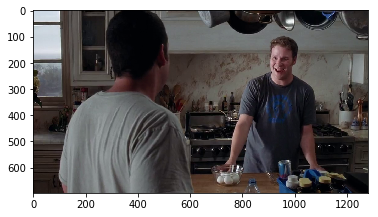

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(array_reloaded[1][0])